In [1]:
from pyspark.sql import SparkSession

In [2]:
spark = SparkSession.builder.appName("Viz").getOrCreate()

your 131072x1 screen size is bogus. expect trouble
25/02/18 10:14:56 WARN Utils: Your hostname, Aniss-PC resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
25/02/18 10:14:56 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/02/18 10:14:56 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
data = spark.read.csv('Dataset/events/Germany - 1. Bundesliga.csv',inferSchema=True, header=True, sep=';')

25/02/18 10:15:09 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


In [4]:
from modules.xG_constants import *
from modules.xG_preprocessing import Preprocessing
from modules.xG_visualization import Visualization
from modules.xG_models import ModelTrainer
from modules.xG_evaluation import ModelEvaluation

### Preprocessing

In [5]:
data = Preprocessing(spark,data)

25/02/18 10:15:26 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [6]:
data.df.show(5,False)

+------------------------------------+---------+--------+-------------+------+------+------+---------------+---------------+----------------+----------+-------------------+-------+-------+-------+-----------+------------+-------+-----------+-------+------+-----------+-------+-------+---------------------+----------------+-------------+------------------+------------------+------------------+--------------+---------------+---------------+---------------+--------------+--------------------+-------------------+--------+-----------+-----------+-----------+---------------+----------+-------------+-----------+-----------------+---------------+----------------+-------------+-------------+------------+------------------+----------+----------+-------------+-----------------+----+
|id                                  |player_id|match_id|team         |period|minute|second|shot_location_x|shot_location_y|distance_to_goal|shot_angle|preferred_foot_shot|from_rp|from_fk|from_ti|from_corner|from_count

### EDA

In [7]:
viz = Visualization(data)

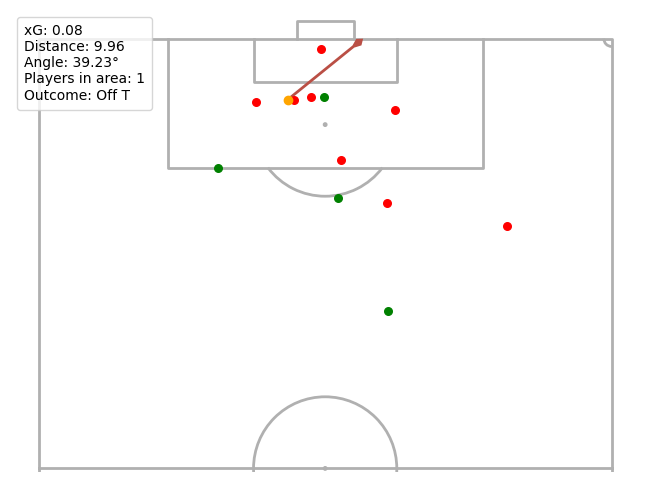

In [8]:
viz.ShotFrame('e4e84ae4-7a2e-490a-9a14-5d37b94b1252')

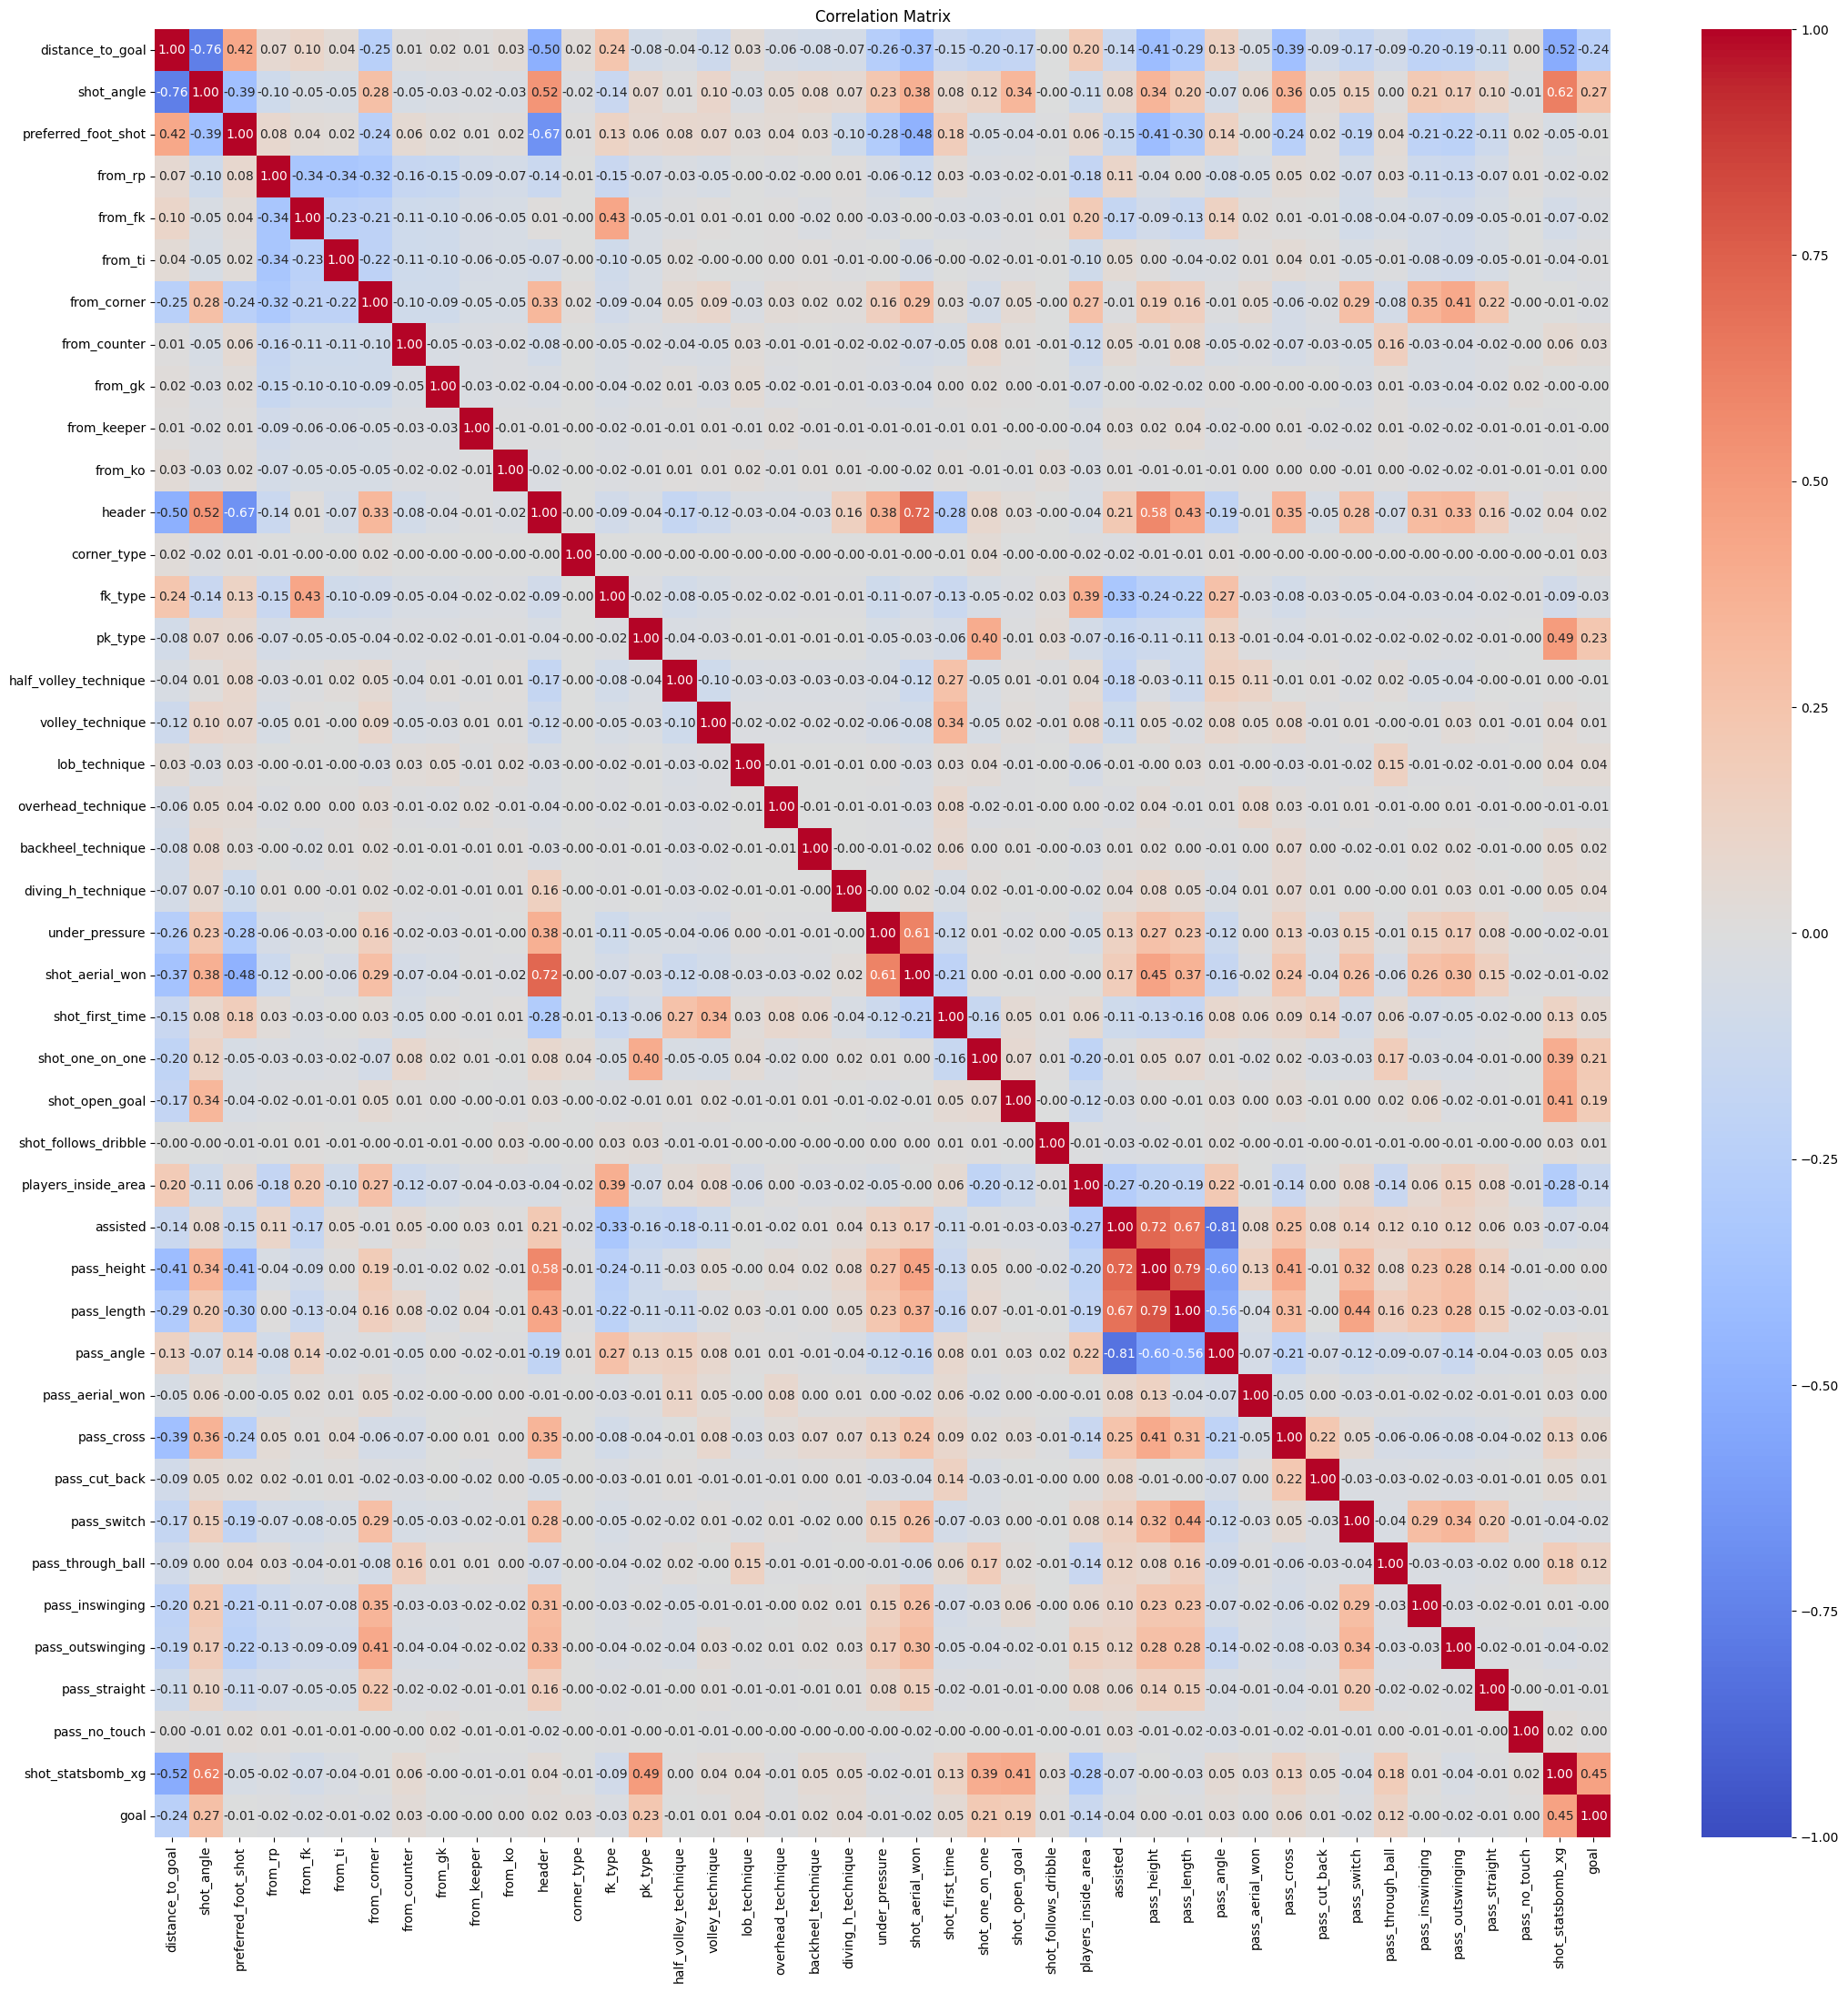

In [9]:
viz.Correlation()

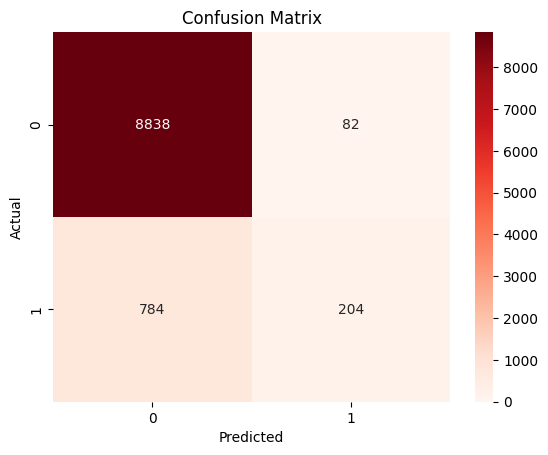

In [10]:
viz.ConfusionMatrix(predicted='sb_prediction')

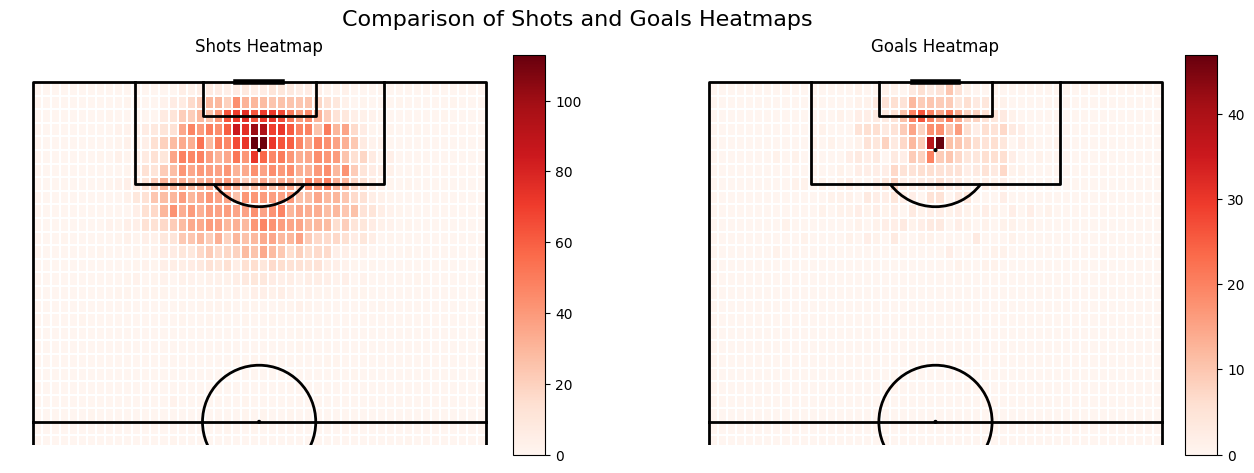

In [11]:
viz.ShotGoalHeatMap()

### Model Training

In [7]:
train_data, test_data = data.data_split()

In [8]:
model = ModelTrainer(train_data, test_data)

25/02/18 10:15:56 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
25/02/18 10:15:56 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


In [9]:
model.predictions.show(5)

+--------------------+---------+--------+----------------+------+------+------+---------------+---------------+----------------+----------+-------------------+-------+-------+-------+-----------+------------+-------+-----------+-------+------+-----------+-------+-------+---------------------+----------------+-------------+------------------+------------------+------------------+--------------+---------------+---------------+---------------+--------------+--------------------+-------------------+--------+-----------+-----------+----------+---------------+----------+-------------+-----------+-----------------+---------------+----------------+-------------+-------------+------------+------------------+----------+----------+-------------+-----------------+----+--------------------+--------------------+--------------------+----------+----------------+
|                  id|player_id|match_id|            team|period|minute|second|shot_location_x|shot_location_y|distance_to_goal|shot_angle|pr

### Evaluation

In [35]:
ModelEvaluation(model.predictions).get_all_metrics()

{'Accuracy': 90.27,
 'Precision': 58.49,
 'Recall': 19.14,
 'Specificity': 98.44,
 'F1': 28.84,
 'FPR': 1.56,
 'FNR': 80.86}

In [36]:
ModelEvaluation(model.predictions,'sb_prediction').get_all_metrics()

{'Accuracy': 97.97,
 'Precision': 69.81,
 'Recall': 69.81,
 'Specificity': 98.95,
 'F1': 69.81,
 'FPR': 1.05,
 'FNR': 30.19}

In [37]:
ModelEvaluation(model.predictions,'shot_statsbomb_xg','goal_probability','regression').get_all_metrics()

{'MSE': 0.00504, 'RMSE': 0.07102, 'MAE': 0.03982, 'R2': 76.54}

### Graph

In [10]:
model.predictions.groupBy('match_id').count().orderBy('count',ascending=False).show(3)

+--------+-----+
|match_id|count|
+--------+-----+
| 3890367|   13|
| 3890419|   12|
| 3890446|   12|
+--------+-----+
only showing top 3 rows



In [59]:
import pyspark.sql.functions as F
from pyspark.sql.window import Window

d = model.predictions.filter((F.col('match_id')==3890446) & (F.col('period')<5))
window_spec = Window.partitionBy('match_id','team').orderBy('minute','second').rowsBetween(Window.unboundedPreceding,
                                                                                 Window.currentRow)
df = d.withColumn('sb_CxG',
                  F.sum('shot_statsbomb_xg').over(window_spec))\
                      .withColumn('CxG',
                  F.sum('goal_probability').over(window_spec))

impo = ['match_id','period','team','minute','second','shot_statsbomb_xg','goal_probability','sb_CxG','CxG','goal']
df.orderBy('minute').select(impo).show()

+--------+------+-------------+------+------+-----------------+----------------+-----------+-------------------+----+
|match_id|period|         team|minute|second|shot_statsbomb_xg|goal_probability|     sb_CxG|                CxG|goal|
+--------+------+-------------+------+------+-----------------+----------------+-----------+-------------------+----+
| 3890446|     1|Bayern Munich|     8|    44|       0.02727597|    0.0450961208| 0.02727597|       0.0450961208|   0|
| 3890446|     1|Bayern Munich|    14|    52|       0.08700968|    0.1557993422| 0.11428565|        0.200895463|   1|
| 3890446|     1|Bayern Munich|    21|    11|       0.09530696|     0.115374581| 0.20959261|0.31627004400000003|   0|
| 3890446|     1|Bayern Munich|    45|     2|      0.010402888|    0.0252379656|0.219995498|0.34150800960000005|   0|
| 3890446|     2|     Augsburg|    52|    56|      0.026839456|    0.0297229138|0.026839456|       0.0297229138|   0|
| 3890446|     2|Bayern Munich|    63|    24|      0.041

In [60]:
df_p = df.select(impo).orderBy('minute').toPandas()

In [61]:
team1,team2 = df_p[~df_p['team'].isna()]['team'].unique()

In [62]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

i = 91 if df_p['minute'].max()<90 else df_p['minute'].max()+1

mins_range = np.arange(0,i)
sec_range = np.arange(0,60)
ft = pd.DataFrame([(m,s) for m in mins_range for s in sec_range],columns=['minute','second'])

df_f1 = df_p[df_p['team']==team1]
df_f2 = df_p[df_p['team']==team2]

df_f1 = ft.merge(df_f1, on=('minute','second'),how='left')
df_f2 = ft.merge(df_f2, on=('minute','second'),how='left')


df_f1['sb_CxG'] = df_f1['sb_CxG'].ffill().fillna(0)
df_f2['sb_CxG'] = df_f2['sb_CxG'].ffill().fillna(0)

df_f1['CxG'] = df_f1['CxG'].ffill().fillna(0)
df_f2['CxG'] = df_f2['CxG'].ffill().fillna(0)

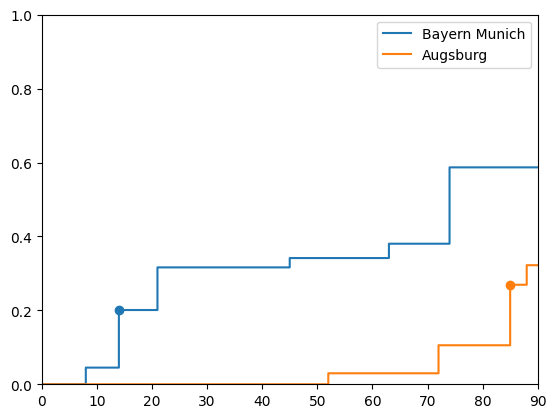

In [63]:
team1=df_f1[~df_f1['team'].isna()]['team'].unique()[0]
team2=df_f2[~df_f2['team'].isna()]['team'].unique()[0]

plt.plot(df_f1['minute'],df_f1['CxG'],label=team1)
plt.plot(df_f2['minute'],df_f2['CxG'],label=team2)
plt.scatter(df_f1[df_f1['goal']==1]['minute'],df_f1[df_f1['goal']==1]['CxG'])
plt.scatter(df_f2[df_f2['goal']==1]['minute'],df_f2[df_f2['goal']==1]['CxG'])
plt.xlim((0,90))
plt.ylim((0,1))
plt.legend()
plt.show()